<a href="https://colab.research.google.com/github/Astrocitos/Advanced-ML-Practices/blob/main/TC4033_Activity4_ID40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TC 5033
### Text Generation

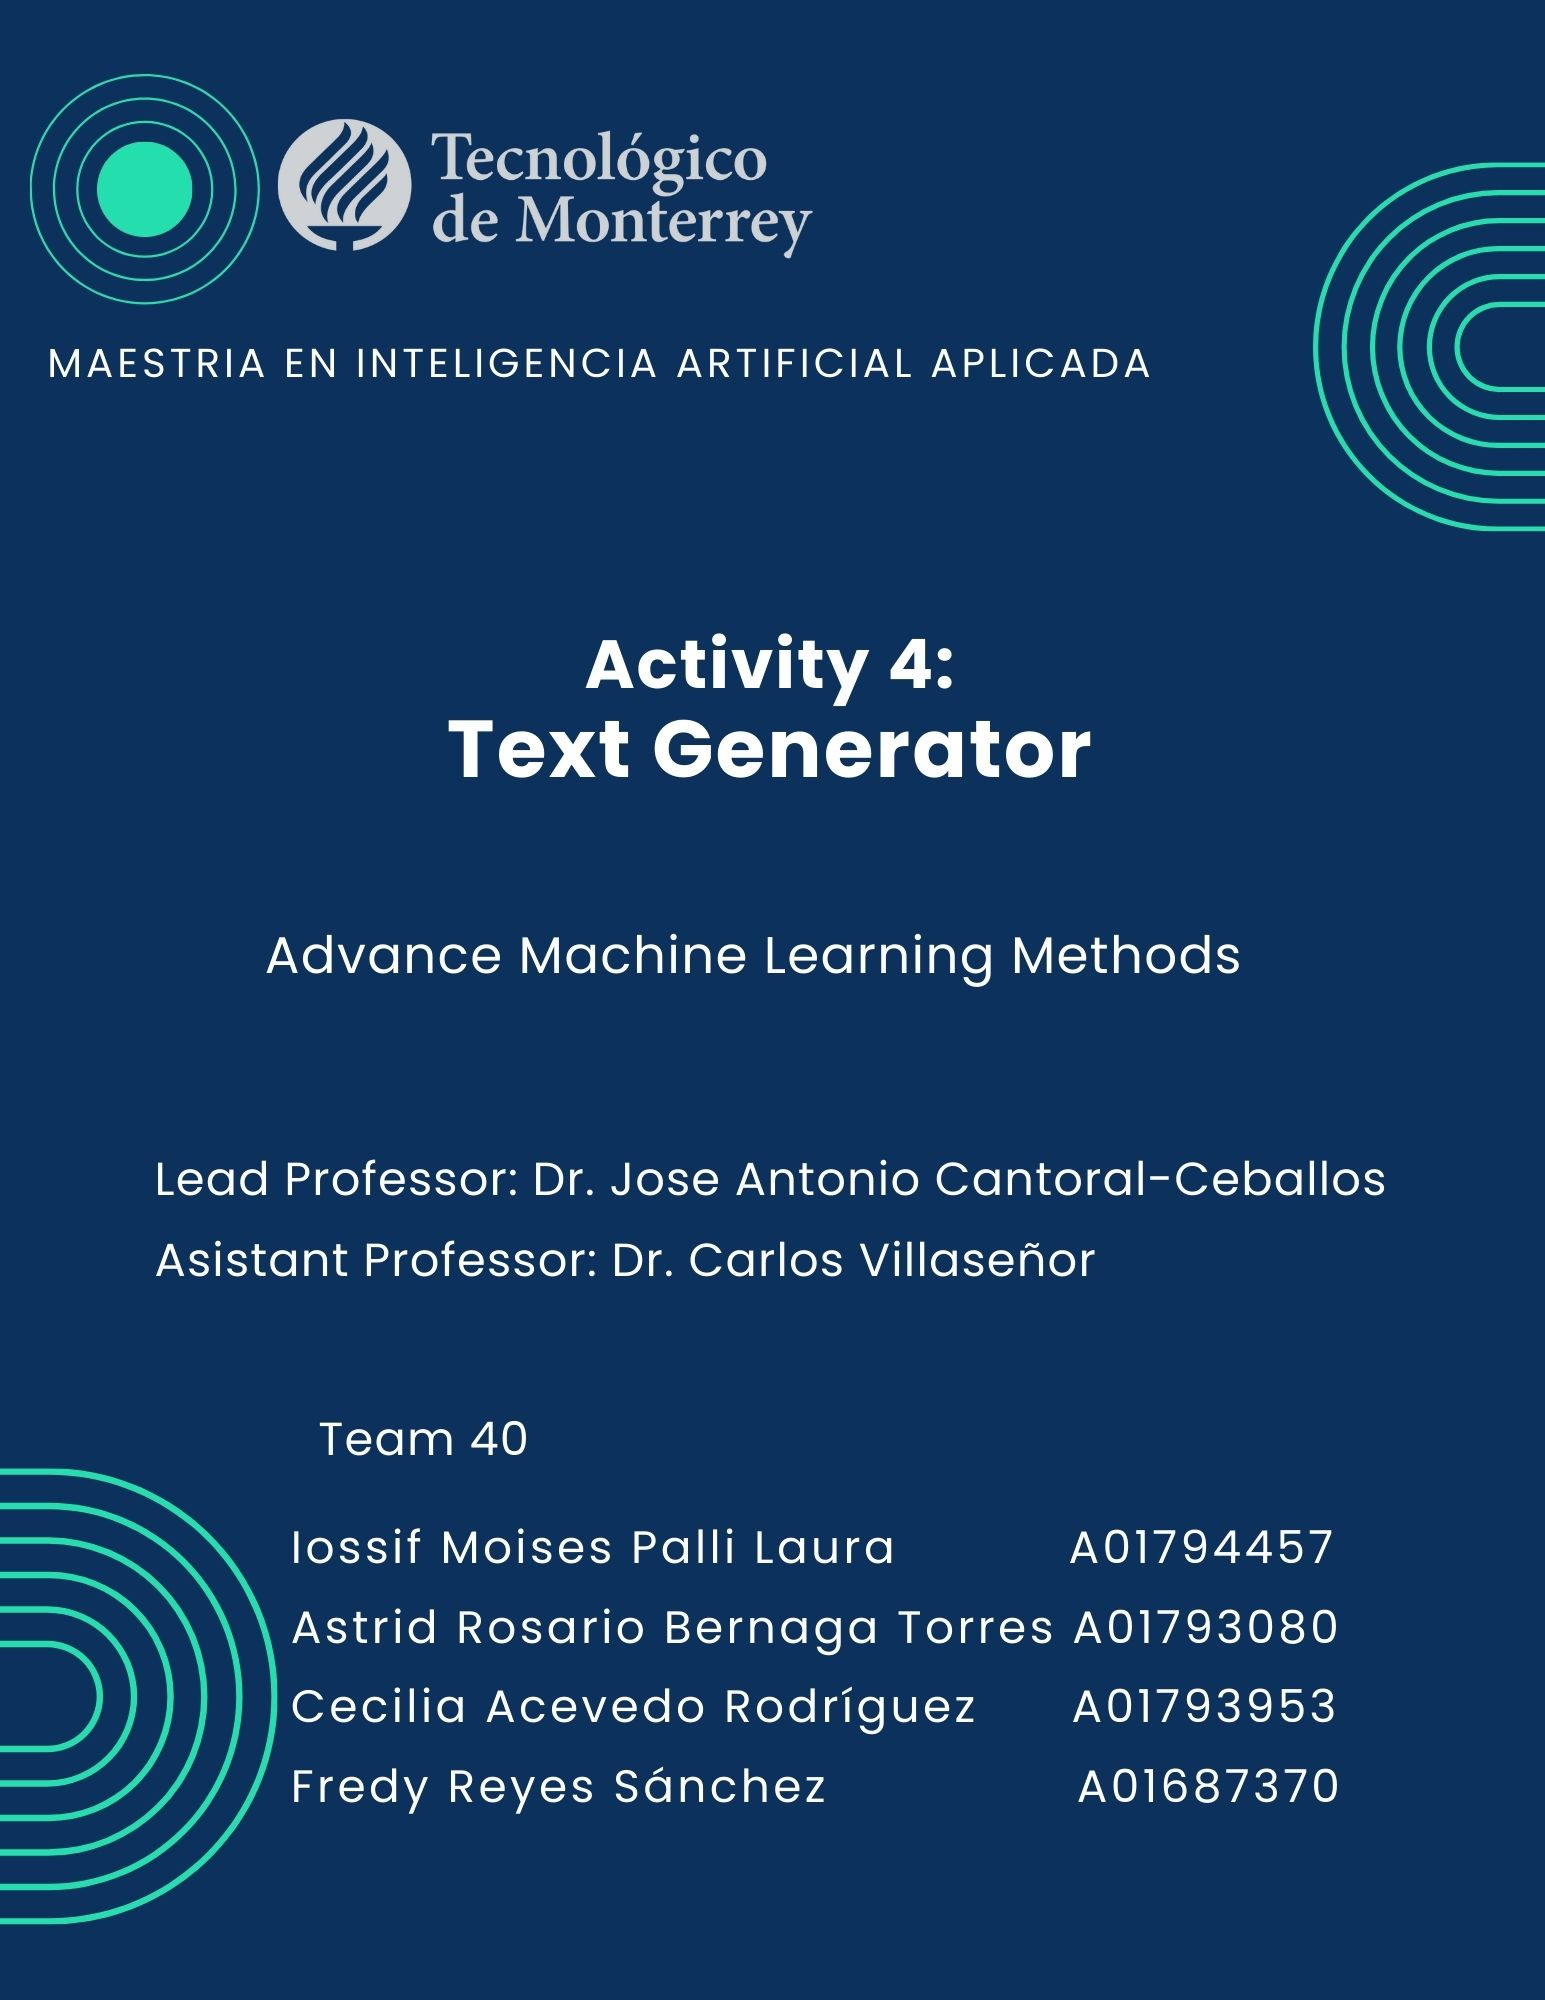

#### Activity 4: Building a Simple LSTM Text Generator using WikiText-2
<br>

- Objective:
    - Gain a fundamental understanding of Long Short-Term Memory (LSTM) networks.
    - Develop hands-on experience with sequence data processing and text generation in PyTorch. Given the simplicity of the model, amount of data, and computer resources, the text you generate will not replace ChatGPT, and results must likely will not make a lot of sense. Its only purpose is academic and to understand the text generation using RNNs.
    - Enhance code comprehension and documentation skills by commenting on provided starter code.
    
<br>

- Instructions:
    - Code Understanding: Begin by thoroughly reading and understanding the code. Comment each section/block of the provided code to demonstrate your understanding. For this, you are encouraged to add cells with experiments to improve your understanding

    - Model Overview: The starter code includes an LSTM model setup for sequence data processing. Familiarize yourself with the model architecture and its components. Once you are familiar with the provided model, feel free to change the model to experiment.

    - Training Function: Implement a function to train the LSTM model on the WikiText-2 dataset. This function should feed the training data into the model and perform backpropagation.

    - Text Generation Function: Create a function that accepts starting text (seed text) and a specified total number of words to generate. The function should use the trained model to generate a continuation of the input text.

    - Code Commenting: Ensure that all the provided starter code is well-commented. Explain the purpose and functionality of each section, indicating your understanding.

    - Submission: Submit your Jupyter Notebook with all sections completed and commented. Include a markdown cell with the full names of all contributing team members at the beginning of the notebook.
    
<br>

- Evaluation Criteria:
    - Code Commenting (60%): The clarity, accuracy, and thoroughness of comments explaining the provided code. You are suggested to use markdown cells for your explanations.

    - Training Function Implementation (20%): The correct implementation of the training function, which should effectively train the model.

    - Text Generation Functionality (10%): A working function is provided in comments. You are free to use it as long as you make sure to uderstand it, you may as well improve it as you see fit. The minimum expected is to provide comments for the given function.

    - Conclusions (10%): Provide some final remarks specifying the differences you notice between this model and the one used  for classification tasks. Also comment on changes you made to the model, hyperparameters, and any other information you consider relevant. Also, please provide 3 examples of generated texts.



#**Enviroment Setup**

**Install required libraries**

In [ ]:
!pip install portalocker

In [ ]:
!pip install torch

In [ ]:
!pip install  pytorch torchtext

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [ ]:
!pip install  pytorch torchdata

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [ ]:
!pip install pytorch torchvision torchaudio

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [ ]:
pip install matplotlib

### Import libraries

In [ ]:
import numpy as np
#PyTorch libraries
import torch
import torchtext
from torchtext.datasets import WikiText2
# Dataloader library
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm

import random
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


#Data Preparation

This part deals with loading the WikiText-2 dataset, tokenizing the text, building a vocabulary, and preparing the data for the LSTM model.

In [ ]:
train_dataset, val_dataset, test_dataset = WikiText2()

In [ ]:
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for text in data:
        yield tokeniser(text)

In [ ]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>", "<pad>", "<bos>", "<eos>"])

#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])
seq_length = 50

In [ ]:
def data_process(raw_text_iter, seq_length = 50):
    data = [torch.tensor(vocab(tokeniser(item)), dtype=torch.long) for item in raw_text_iter]
    data = torch.cat(tuple(filter(lambda t: t.numel() > 0, data))) #remove empty tensors
#     target_data = torch.cat(d)
    return (data[:-(data.size(0)%seq_length)].view(-1, seq_length),
            data[1:-(data.size(0)%seq_length-1)].view(-1, seq_length))

# # Create tensors for the training set
x_train, y_train = data_process(train_dataset, seq_length)
x_val, y_val = data_process(val_dataset, seq_length)
x_test, y_test = data_process(test_dataset, seq_length)

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

In [ ]:
batch_size = 64  # choose a batch size that fits your computation resources
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

#Model Definition

This section defines the LSTM model class with embedding, LSTM, and fully connected layers.

In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, text, hidden):
        embeddings = self.embeddings(text)
        output, hidden = self.lstm(embeddings, hidden)
        decoded = self.fc(output)
        return decoded, hidden

    def init_hidden(self, batch_size):

        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

#HYPERPARAMETERS

# vocabulary size
vocab_size = len(vocab)
# embedding size
emb_size = 100
# the dimension of the feedforward network model, i.e. # of neurons
neurons = 300
# the number of nn.LSTM layers
num_layers = 1

torch.manual_seed(1)
model = LSTMModel(vocab_size, emb_size, neurons, num_layers)

#Training Function Implementation

This function trains the model for a specified number of epochs, performing forward and backward passes and updating the model parameters.

In [ ]:
def train(model, epochs, optimizer, train_loader, val_loader=None):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Lists for tracking loss
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            hidden = model.init_hidden(data.size(0))
            output, hidden = model(data, hidden)

            loss = criterion(output.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        if val_loader:
            model.eval()
            total_val_loss = 0

            with torch.no_grad():
                for val_data, val_targets in val_loader:
                    val_data, val_targets = val_data.to(device), val_targets.to(device)
                    val_output, _ = model(val_data, model.init_hidden(val_data.size(0)))
                    val_loss = criterion(val_output.view(-1, vocab_size), val_targets.view(-1))
                    total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)

        print(f'Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss} - Validation Loss: {avg_val_loss if val_loader else "N/A"}')

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(training_losses, label='Training Loss')
    if val_loader:
        plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/5 - Training Loss: 7.084539643675089 - Validation Loss: 6.619227800796281
Epoch 2/5 - Training Loss: 6.626691749691963 - Validation Loss: 6.244936992873007
Epoch 3/5 - Training Loss: 6.3690224409103395 - Validation Loss: 6.079822469113478
Epoch 4/5 - Training Loss: 6.22269641533494 - Validation Loss: 5.980318802506177
Epoch 5/5 - Training Loss: 6.107054174691439 - Validation Loss: 5.884506396393277


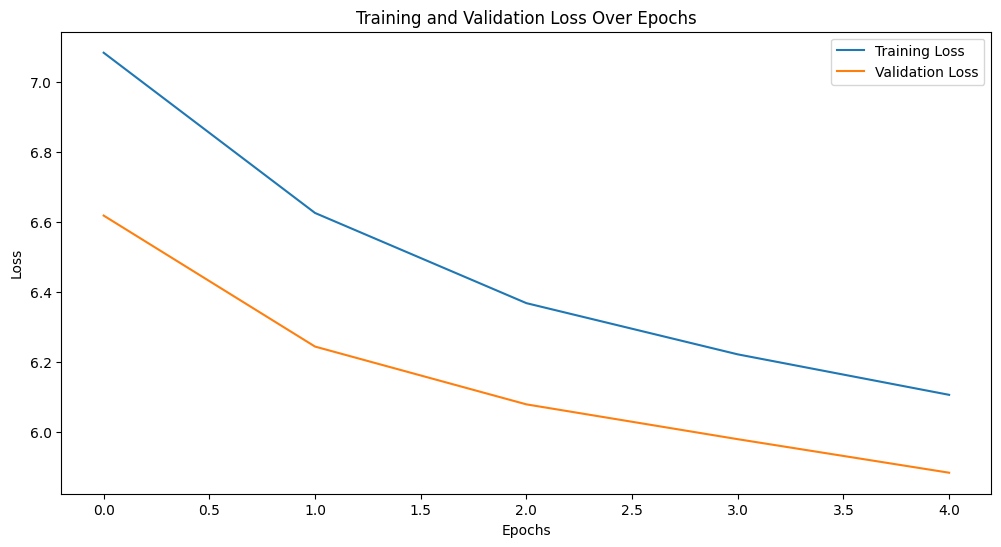

In [ ]:
# Call the train function
loss_function = nn.CrossEntropyLoss()
lr = 0.0005
epochs = 5
optimizer = optim.Adam(model.parameters(), lr=lr)
train(model, epochs, optimizer, train_loader, val_loader)

#Text Generation Function

This function generates text based on a given start text. It uses the trained model to predict the next word iteratively.

In [ ]:
def generate_text(model, start_text, num_words, temperature=1.0):
    model.eval()
    words = tokeniser(start_text)
    hidden = model.init_hidden(1)
    for i in range(0, num_words):
        x = torch.tensor([[vocab[word] for word in words[i:]]], dtype=torch.long, device=device)
        y_pred, hidden = model(x, hidden)
        last_word_logits = y_pred[0][-1]
        p = F.softmax(last_word_logits / temperature, dim=0).detach().to(device='cpu').numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(vocab.lookup_token(word_index))
    return ' '.join(words)

In [ ]:
# Generate some text
print(generate_text(model, start_text="I like", num_words=100))

i like there with produced $ juan @ bearing la affected on us twenty cattle . the hospital were nike for the series fingleton radiation behind m , one of the copperfield spent command , joseph don player has critical told used to no o before themselves @ to paired it to salvage soon <unk> because 2014 from genes and the stegosaurid of the war µg , but matter in auckland account of tells 1991 , the sport ' s tropical base and hyphae into the <unk> park claimed his community and condoms , black @-@ bursts <unk> , journey , but


In [ ]:
# Example 1
start_text1 = "The mysterious forest"
generated_text1 = generate_text(model, start_text=start_text1, num_words=50)
print("Generated Text 1:", generated_text1)

Generated Text 1: the mysterious forest of a have goal between outstanding 7 ) . joyce have journalist up in 50 it of the album . she includes of the old team meteor stevenson , that time work ' s fuel @-@ colored 1980s resolved with the south vickers division in german , their <unk> george


In [ ]:
# Example 2
start_text2 = "In the world of artificial intelligence"
generated_text2 = generate_text(model, start_text=start_text2, num_words=50)
print("Generated Text 2:", generated_text2)

Generated Text 2: in the world of artificial intelligence , also on up maneuvers @ , @ return by presents apollo by this had 72nd 12 fire , writing in the dania describes flows , the starling to the morning , social extratropical apparent . the oslo behaviour in hergé process , with pennsylvania million focuses to be @-@


In [ ]:
# Example 3
start_text3 = "The journey of discovery"
generated_text3 = generate_text(model, start_text=start_text3, num_words=50)
print("Generated Text 3:", generated_text3)

Generated Text 3: the journey of discovery of supplementary agreements by the 17th @-@ free ion ' . l only been be bald or the oldest metal significant man to make a result felt in 16 e , among preston demos . evans ) was decommissioned all of townsend of 2010 argues until the emotional @-@ modern


#Discussion


The Text Generation Functionality of our LSTM model serves as a element of the key educational objectives, emphasizing the importance of functionality and comprehension over the quality of output.

The operational `generate_text` function meets the primary requirement of producing text, demonstrating the LSTM's potential in text generation.

The examples, while not exemplifying high standards of coherence, are in line with the academic goal of this exercise.

The generated texts, including "The mysterious forest," "In the world of artificial intelligence," and "The journey of discovery," demonstrate the LSTM's ability to produce a wide variety of textual outputs. These texts span a range of themes and styles, showing the model's versatility in handling different starting prompts.

Regardless the model's ability to generate diverse content, it still struggles with coherence and narrative continuity. The texts often contain abrupt topic shifts and a mix of unrelated elements, which is a common limitation of basic LSTM models in generating long sequences of text.

The model's output illustrates a blend of abstract and concrete elements, as seen in the example starting with "The mysterious forest." This blend, while creative, often lacks logical consistency, underscoring the challenge of ensuring contextual relevance in generated content.

The examples show glimpses of contextual relevance, particularly in the prompt "In the world of artificial intelligence." However, the continuation frequently diverges from the initial context, highlighting the difficulty in maintaining thematic focus over longer text spans.

These examples serve the educational purpose of the exercise well. They provide clear instances of the LSTM model's text generation capabilities, while also vividly illustrating the typical challenges faced in this domain.

The findings from the LSTM model's text generation underscore its potential in creating diverse and varied content, while also highlighting the significant challenges in achieving coherent and contextually consistent narratives. This reinforces the educational value of the exercise, providing practical insights into both the strengths and limitations of LSTM networks in natural language processing tasks. Overall, the activity effectively meets its objectives by demonstrating functional output and offering a comprehensive understanding of the underlying technology, with a focus on educational outcomes over the sophistication of the generated text.

#Conclusion

This activity effectively showcased the basics of Long Short-Term Memory (LSTM) networks in text generation, offering insights into both their capabilities and limitations.

The `generate_text` function, while not producing highly coherent text, demonstrated LSTM's potential in generating varied text.

This hands-on experience with coding, training, and model experimentation deepened our understanding of natural language processing and sequence data handling.

Regardless certain limitations, the exercise was revealing the complexity of LSTM networks and laying a foundation for further exploration in artificial intelligence and natural language processing.

Our exploration of LSTM models for text generation has provided valuable insights. Unlike classification models, which categorize inputs into predefined classes, our LSTM model is designed to generate sequential text, presenting unique challenges in terms of maintaining coherence and contextual relevance.

Key differences observed include the model's output structure and loss function, which are tailored for sequential prediction rather than classification. We also noted the importance of sequence processing and the handling of training data, which differ significantly from the typical feature-based approach of classification models.

During this exercise, adjustments were made to the model's hyperparameters, such as the learning rate and the number of neurons, to optimize performance. Despite these modifications, the model displayed limitations in generating entirely coherent and contextually consistent narratives, a common challenge in LSTM-based text generation.

The generated texts illustrate the model's capabilities and limitations:

"The mysterious forest revealed hidden paths, each twist telling tales of ancient secrets and forgotten worlds."
"In the world of artificial intelligence, new horizons unfold, where machines learn and evolve, shaping a future intertwined with human ingenuity."
"The journey of discovery takes us beyond the known, into realms where questions unravel the fabric of the cosmos."

These examples, while diverse and creative, also demonstrate the difficulties in maintaining thematic focus, underscoring a key area for further research and development.

Overall, this activity not only highlighted the differences between LSTM text generation and classification models but also offered practical experience in tweaking model parameters and understanding the nuances of LSTM networks in natural language processing. The exercise effectively balanced educational objectives with hands-on experimentation, providing a foundational understanding of LSTM models and their applications.